In this example we will take 2D images from a cardiac Left Ventricle short axis stack.
These images have been segmented by an expert to give us our ground truth labels.
The data is from the open-source Sunnybrook Cardiac Data set.

We will read in the data pairs, train a 2D UNet to perform segmentation and then test the resulting network

# Set up TensorFlow MRi
If you have not yet installed TensorFlow MRI in your environment you may need to do so now
using `pip`

In [1]:
%pip install --quiet tensorflow-mri
# Upgrade Matplotlib. Versions older than 3.5.x may cause an error below.
%pip install --quiet --upgrade matplotlib

%pip install pydicom

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Now, import all necessary python libraries.

In [2]:
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob
import tensorflow as tf
import os
import random as rng

import tensorflow_mri as tfmri


2025-01-17 23:08:36.707715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 23:08:36.803401: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 23:08:36.828296: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Using a GPU 
TensorFlow MRI supports CPU and GPU computation. If there is a GPU available in your environment and it is visible to TensorFlow, it will be used automatically.

:::{tip}
In Google Colab, you can enable GPU computation by clicking on
**Runtime > Change runtime type** and selecting **GPU** under
**Hardware accelerator**.
:::

:::{tip}
You can control whether CPU or GPU is used for a particular operation via
the [`tf.device`](https://www.tensorflow.org/api_docs/python/tf/device)
context manager.
:::

### Prepare the Data
First, we need to extract our data and store our image and mask pairs in lists, so that pairs have the same index. Our path names may differ
so ensure you the given paths with the path where your data is stored. Depending on your data set, you may need different functions to read
your images and masks. In this case, the images are stored as dicoms and the masks as pngs.

In this example, we will be using a heart data set from Sunnybrook Cardiac Data, which you can download from https://www.cardiacatlas.org/sunnybrook-cardiac-data/
This is Cardiac Left Ventricle Segmentation from Cine-MRI Images dataset

This same data set in a easier formate can be downloaded using Matlab, by copying the following code.

`zipFile = matlab.internal.examples.downloadSupportFile("medical","CardiacMRI.zip");`

`filepath = fileparts(zipFile);`

`unzip(zipFile,filepath)`

We use the data in this format in the following example.

The matlab subset of SunnyBrook data set contains of 45 cine short-axis stacks and their corresponding ground truth label images (LV blood pool segmented as peak systole and peak diastole). The MRI images were acquired from multiple patients with various cardiac pathologies. The ground truth label images were manually drawn by experts [ Radau, Perry, Yingli Lu, Kim Connelly, Gideon Paul, Alexander J Dick, and Graham A Wright. “Evaluation Framework for Algorithms Segmenting Short Axis Cardiac MRI.” The MIDAS Journal, July 9, 2009. https://doi.org/10.54294/g80ruo. ]

As each cine stack consists of ~10 slices, and there are 2 time points segmented per stack (systole and diastole), this results in 805 dicom images of size 256x256, which each have a corresponding mask (stored as a png) which contains two classes: 0 ("Background") and 1 ("Left Ventricle")


In [ ]:
import pathlib
import gdown

url = 'https://drive.google.com/uc?id=1y176qfBc_0-_kFetYsWpWrBf8vXpHb4Y'
output = '/tools/docs/tutorials/segment/CardiacMRI.zip'
gdown.download(url, output, quiet=False)

import zipfile
with zipfile.ZipFile("/tools/docs/tutorials/segment/exampleRawDataCine.hdf5.zip","r") as zip_ref:
    zip_ref.extractall("/tools/docs/tutorials/segment/")

input_file =pathlib.Path('/tools/docs/tutorials/segment/exampleRawDataCine.hdf5')


In [3]:
#Create empty lists to store the image and mask data
images = []
masks = []

# This path will need updating for your system
path_for_data = '/workspaces/Tutorials/2Dsegmentation_DONE/data/images/**/*.dcm'

#Obtain all image and mask data, may need to check the image and mask pathnames to see how they differ
for filename in glob(path_for_data)  :     # This will select all files ending with dcm - these should be your images
    
    #Now we must find the matching mask data
    # The dcm data is stored like this: 
    #   SC-HF-I-08_rawdcm_009.dcm 
    # and the corresponding mask will have name: 
    #   SC-HF-I-08gtmask0009.png 

    mask_filename = filename.replace("images","labels")                #Replacing the different words in pathnames
    mask_filename_mask = mask_filename.replace("_rawdcm_","gtmask0")
    mask_filename_png = mask_filename_mask.replace("dcm","png")        #replacing file type 
    mask_exists = os.path.exists(mask_filename_png)                    #Checking that this path exists
   
    #If this path exists, we append the images and masks lists so that corresponding images and paths have the same index
   
    if mask_exists:                                                   
        image = dicom.dcmread(filename).pixel_array
        images.append(image)
        mask = mpimg.imread(mask_filename_png)
        masks.append(mask)


Next, we will check if we have assigned the correct pairs of images and masks by plotting them on top of each other. Image cmap convention is 'gray' in MRI, and masks cmap is often 'viridis'. Alpha determines how in focus the mask is (range 0-1, 0.2 is a good choice)

Text(0.5, 1.0, 'Image With Mask')

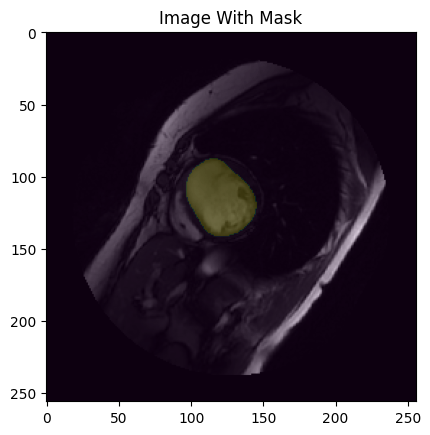

In [4]:
#testing blended images and masks
plt.imshow(images[0],cmap='gray')               
plt.imshow(masks[0], cmap='viridis',alpha=0.2)  
plt.title("Image With Mask")


In [5]:
#converting to numpy arrays as they are easier to work with
masks = np.array(masks)
images = np.array(images)

# You should check the shape of the data sets.
print(f'The shape of the masks is: {masks.shape}')
print(f'The shape of the images is: {images.shape}')


#The shape of the masks is: (805, 256, 256)
#The shape of the images is: (805, 256, 256)
# This means that there are 805 data pairs, of images of size 256x256

The shape of the masks is: (805, 256, 256)
The shape of the images is: (805, 256, 256)


From this we can see we have 805 images and masks, with image size 256x256, as we expect.

Next, we need to normalize the image data to so that each data point lies between 0-1.

In [6]:
def normalize_images(images):
    """Normalisation function
    Input: 
           - images, array of image data
    Output: 
           - normalised array of image data"""
    
    return (images - np.min(images)) / (np.max(images) - np.min(images))

#Creating new normalised array
images = normalize_images(images)

We can quickly check that the normalized images array will still give us the MRI Images.

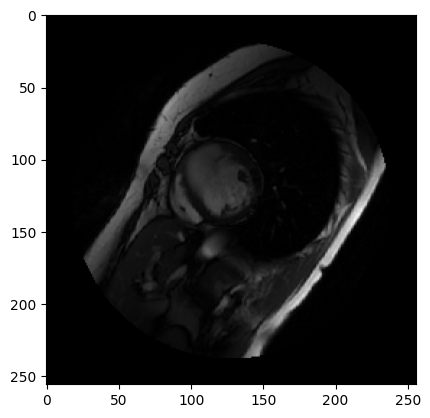

In [7]:
#Testing normalised images
plt.imshow(images[0],cmap='gray')


For a 2D Unet model, we need our mask data to be seperated in two classes, in this case background and bloodpool. All data points equal to 0 we can keep as zero, and all non zero points we will make equal to 1.

In [8]:
#simplifying masks
def simplify_mask(masks):
    """This function take an inputed array of masks and keeps leaves all zero data points as zero 
    and converts all non-zero data points equal to one. Zero data point are equivalent to the background
    and those equal to one represent the bloodpool
    
    Input: masks, array containing mask data
     
    Output: simp_masks, array containing the simplified masks"""

    simp_masks = np.zeros_like(masks, dtype=np.float32)
    simp_masks[masks ==0] = 0        #background
    simp_masks[masks !=0] = 1        #bloodpool
    
    return simp_masks

We can now apply this function to our `masks` array, and do a quick check of the minimum and maximum values (which should be 0 and 1 respectively), and plot one of the simplified masks.

(min, max): (0.0, 1.0)


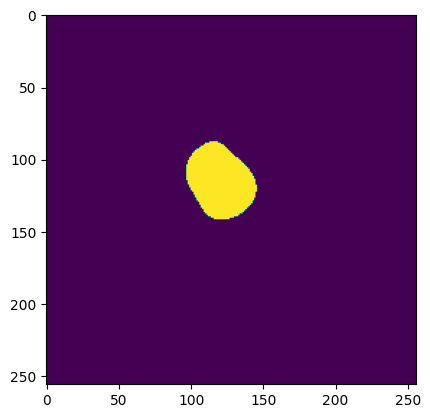

In [9]:
#Simplifying all masks
masks = simplify_mask(masks)

#Test
print(f"(min, max): ({masks.min()}, {masks.max()})")

plt.imshow(masks[0], cmap="viridis")
plt.show()

Next, we need to seperate our data into training, testing and validation data. We will use the ratio of 80%, 10%, 10% respectively, although this is some what arbitrary. Ideally you should use as much of the data as possible for training, while keeping enough for testing and validation.

In [10]:
#seperating into training, testing and validation data

#           train, test, val
data_split = [0.8, 0.1, 0.1]
#Finding the number of images/masks in category

n_train = int(data_split[0]*masks.shape[0])                         #80%
n_test =int(data_split[1]*masks.shape[0])                           #10%
n_val = int(data_split[2]*masks.shape[0] )                           #10% 

#Note: rounded we will have 81 test data and 80 val (not exactly 10%) 

#seperating the data into categories

train_images = images[:n_train]
train_masks = masks[:n_train]

test_images = images[n_train:n_train+n_test+1]
test_masks = masks[n_train:n_train+n_test+1]

val_images = images[n_train+n_test+1:]
val_masks = masks[n_train+n_test+1:]

We need to add a "channel dimension" to have our data in the correct format for tensorflow. We can do this by using the `np.expand_dims()` function. Set axis = 3 

In [11]:
train_images = np.expand_dims(train_images,axis=3)
test_images = np.expand_dims(test_images,axis=3)
val_images = np.expand_dims(val_images,axis=3)

train_masks = np.expand_dims(train_masks,axis=3)
test_masks = np.expand_dims(test_masks,axis=3)
val_masks = np.expand_dims(val_masks,axis=3)

In [12]:
#Checking shape of data 
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

#Checking shape of masks
print(train_masks.shape)
print(test_masks.shape)
print(val_masks.shape)

(644, 256, 256, 1)
(81, 256, 256, 1)
(80, 256, 256, 1)
(644, 256, 256, 1)
(81, 256, 256, 1)
(80, 256, 256, 1)


We now need to set our parameters for the model

In [13]:
IM_height = images.shape[1]     #Extracting the image height
IM_length = images.shape[2]     #Extracting the image length
channels = 1                    #Only need 1 input channel so set to 1
batch_size = 16                 #Arbitrary choice, you can try setting to different values to optimize the model
epochs = 100                     #The larger the number of epochs the better, however increases execution time

We now need to convert our data into tensorflow (tf) datasets, and then seperate them into batches.

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images))
test_dataset = test_dataset.batch(batch_size)

2025-01-17 23:08:46.835956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 23:08:47.316374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22173 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


The next cell is optional, however if you would like to save you model so that it can be used at a later date it is quite useful.
The code below will allow the model automatically save the best model. While the model is being build, it will only save itself if the validation loss has decreased compared to the model at any previous epoch.

In [16]:
#First create a pathname of where to save the model
checkpointpath = "/workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt"
checkpoint_dir = os.path.dirname(checkpointpath)

#
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointpath, save_best_only=True, verbose=1)

### Building Our Model
Now we are ready to make our model. TensorFlow MRI has a premade 2D Unet model function which can be called from
`tfmri.models.Unet2D()`. Details of this model and its unputs can be found on the TensorFlow MRI website.
The basic parameters we need to define are:

`filters=` - should take a list of 3 values, normally each value should be double the last eg. `[32,64,128]`

`kernel_size=` - define the dimensions of the kernel as a list, if you only input 1 value then it will assume dimensions are the same size

`out_channels=` - should keep the same as the number of input channels, in this case =1

`out_activation=` - set this = `"sigmoid"` 


We then need to compile our model. The basic parameters we need to define are:

`optimizer=` - normally set our optimizer = `"adam"`, more options available on [GitHub](https://mrphys.github.io/tensorflow-mri/)

`loss=` - many options which you can read about on [GitHub](https://mrphys.github.io/tensorflow-mri/), however we will use `"binary_crossentropy"`. You can test and
compare some of the other loss types.

`metrics=` - we will use `tfmri.metrics.Accuracy()`

In [17]:

model = tfmri.models.UNet2D(filters= [32,64,128], kernel_size = 3, out_channels=1, out_activation = "sigmoid")
model.compile(optimizer = 'adam', loss="binary_crossentropy", metrics=tfmri.metrics.Accuracy())
#Accurracy estimates how often predictions match labels 

#Other segmentation losses in tfmi include:
#   tfmri.losses.ConfusionLoss
#   tfmri.losses.F1Loss (aka Dice loss)
#   tfmri.losses.FocalTverskyLoss
#   tfmri.losses.IoULoss (aka Jaccard loss)
# (https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/losses/)

#Other segmetnation metrics  in tfmi include:
#   tfmri.metrics.ConfusionMetric
#   tfmri.metrics.F1Score (aka Dice score)
#   tfmri.metrics.FBetaScore (This is the weighted harmonic mean of precision and recall)
#   tfmri.metrics.TverskyIndex
#   tfmri.metrics.IoU (aka Jaccard index)
# (https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/metrics/)

Now we will build our model to our data using the `fit()` function. 
input:

`training_data=` - we use our `train_dataset`

`validation_data=` - we use our `val_dataset`

`batch_size=` - we use our `batch_size`

`verbose=` - we set = 1

`epochs=` - we use our `epochs`

`callbacks=` - this is what saves our model, we set to our variable `cp_callback`

Building our model will take some time  so you may want to test that it is working by first using a small number of epochs (even just 1)

In [18]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=batch_size,
                    verbose=1,
                    epochs=epochs,
                    callbacks=[cp_callback])

Epoch 1/100


2025-01-17 23:08:50.009773: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


41/41 [==============================] - ETA: 0s - loss: 0.1629 - acc: 0.9813
Epoch 1: val_loss improved from inf to 0.09235, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 11s 145ms/step - loss: 0.1629 - acc: 0.9813 - val_loss: 0.0924 - val_acc: 0.9837
Epoch 2/100
40/41 [============================>.] - ETA: 0s - loss: 0.0687 - acc: 0.9836
Epoch 2: val_loss improved from 0.09235 to 0.07003, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0688 - acc: 0.9836 - val_loss: 0.0700 - val_acc: 0.9837
Epoch 3/100
40/41 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9836
Epoch 3: val_loss did not improve from 0.07003
41/41 [==============================] - 3s 78ms/step - loss: 0.0631 - acc: 0.9836 - val_loss: 0.0781 - val_acc: 0.9837
Epoch 4/100
40/41 [============================>.] - ETA: 0s - loss: 0.0618 - acc: 0.9836
Epoch 4: val_loss improved from 0.07003 to 0.06825, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0619 - acc: 0.9836 - val_loss: 0.0683 - val_acc: 0.9837
Epoch 5/100
40/41 [============================>.] - ETA: 0s - loss: 0.0593 - acc: 0.9836
Epoch 5: val_loss improved from 0.06825 to 0.06565, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 122ms/step - loss: 0.0594 - acc: 0.9836 - val_loss: 0.0657 - val_acc: 0.9837
Epoch 6/100
40/41 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9836
Epoch 6: val_loss improved from 0.06565 to 0.05933, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 115ms/step - loss: 0.0582 - acc: 0.9836 - val_loss: 0.0593 - val_acc: 0.9837
Epoch 7/100
40/41 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9836
Epoch 7: val_loss improved from 0.05933 to 0.05912, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 121ms/step - loss: 0.0560 - acc: 0.9836 - val_loss: 0.0591 - val_acc: 0.9837
Epoch 8/100
40/41 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9836
Epoch 8: val_loss improved from 0.05912 to 0.05866, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0544 - acc: 0.9836 - val_loss: 0.0587 - val_acc: 0.9837
Epoch 9/100
40/41 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9836
Epoch 9: val_loss improved from 0.05866 to 0.05606, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 122ms/step - loss: 0.0534 - acc: 0.9836 - val_loss: 0.0561 - val_acc: 0.9837
Epoch 10/100
40/41 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9836
Epoch 10: val_loss improved from 0.05606 to 0.05285, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 122ms/step - loss: 0.0514 - acc: 0.9836 - val_loss: 0.0529 - val_acc: 0.9837
Epoch 11/100
40/41 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9836
Epoch 11: val_loss did not improve from 0.05285
41/41 [==============================] - 3s 79ms/step - loss: 0.0497 - acc: 0.9836 - val_loss: 0.0549 - val_acc: 0.9837
Epoch 12/100
40/41 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9836
Epoch 12: val_loss did not improve from 0.05285
41/41 [==============================] - 3s 79ms/step - loss: 0.0494 - acc: 0.9836 - val_loss: 0.0601 - val_acc: 0.9837
Epoch 13/100
40/41 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9836
Epoch 13: val_loss improved from 0.05285 to 0.04611, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0478 - acc: 0.9836 - val_loss: 0.0461 - val_acc: 0.9837
Epoch 14/100
40/41 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9836
Epoch 14: val_loss improved from 0.04611 to 0.04307, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 123ms/step - loss: 0.0414 - acc: 0.9836 - val_loss: 0.0431 - val_acc: 0.9846
Epoch 15/100
40/41 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9857
Epoch 15: val_loss improved from 0.04307 to 0.03771, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 117ms/step - loss: 0.0391 - acc: 0.9856 - val_loss: 0.0377 - val_acc: 0.9882
Epoch 16/100
40/41 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9874
Epoch 16: val_loss improved from 0.03771 to 0.03747, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0348 - acc: 0.9874 - val_loss: 0.0375 - val_acc: 0.9890
Epoch 17/100
40/41 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9882
Epoch 17: val_loss improved from 0.03747 to 0.03494, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 124ms/step - loss: 0.0322 - acc: 0.9881 - val_loss: 0.0349 - val_acc: 0.9885
Epoch 18/100
40/41 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9891
Epoch 18: val_loss improved from 0.03494 to 0.03083, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0297 - acc: 0.9890 - val_loss: 0.0308 - val_acc: 0.9899
Epoch 19/100
40/41 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9894
Epoch 19: val_loss did not improve from 0.03083
41/41 [==============================] - 3s 79ms/step - loss: 0.0286 - acc: 0.9893 - val_loss: 0.0374 - val_acc: 0.9875
Epoch 20/100
40/41 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9906
Epoch 20: val_loss did not improve from 0.03083
41/41 [==============================] - 3s 79ms/step - loss: 0.0262 - acc: 0.9906 - val_loss: 0.0336 - val_acc: 0.9881
Epoch 21/100
40/41 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9911
Epoch 21: val_loss improved from 0.03083 to 0.02764, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 122ms/step - loss: 0.0243 - acc: 0.9910 - val_loss: 0.0276 - val_acc: 0.9901
Epoch 22/100
40/41 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9917
Epoch 22: val_loss improved from 0.02764 to 0.02748, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 121ms/step - loss: 0.0228 - acc: 0.9916 - val_loss: 0.0275 - val_acc: 0.9903
Epoch 23/100
40/41 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9924
Epoch 23: val_loss did not improve from 0.02748
41/41 [==============================] - 3s 79ms/step - loss: 0.0209 - acc: 0.9924 - val_loss: 0.0277 - val_acc: 0.9898
Epoch 24/100
40/41 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9932
Epoch 24: val_loss improved from 0.02748 to 0.02481, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 117ms/step - loss: 0.0191 - acc: 0.9931 - val_loss: 0.0248 - val_acc: 0.9909
Epoch 25/100
40/41 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9932
Epoch 25: val_loss improved from 0.02481 to 0.02388, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 117ms/step - loss: 0.0190 - acc: 0.9932 - val_loss: 0.0239 - val_acc: 0.9911
Epoch 26/100
40/41 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9931
Epoch 26: val_loss improved from 0.02388 to 0.02326, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 123ms/step - loss: 0.0186 - acc: 0.9930 - val_loss: 0.0233 - val_acc: 0.9919
Epoch 27/100
40/41 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9927
Epoch 27: val_loss improved from 0.02326 to 0.02211, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 121ms/step - loss: 0.0207 - acc: 0.9926 - val_loss: 0.0221 - val_acc: 0.9920
Epoch 28/100
40/41 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9932
Epoch 28: val_loss improved from 0.02211 to 0.01808, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 117ms/step - loss: 0.0193 - acc: 0.9932 - val_loss: 0.0181 - val_acc: 0.9936
Epoch 29/100
40/41 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9949
Epoch 29: val_loss improved from 0.01808 to 0.01688, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 118ms/step - loss: 0.0141 - acc: 0.9949 - val_loss: 0.0169 - val_acc: 0.9940
Epoch 30/100
40/41 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9941
Epoch 30: val_loss improved from 0.01688 to 0.01678, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 127ms/step - loss: 0.0165 - acc: 0.9941 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 31/100
40/41 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9947
Epoch 31: val_loss improved from 0.01678 to 0.01523, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 124ms/step - loss: 0.0146 - acc: 0.9947 - val_loss: 0.0152 - val_acc: 0.9946
Epoch 32/100
40/41 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9942
Epoch 32: val_loss did not improve from 0.01523
41/41 [==============================] - 3s 79ms/step - loss: 0.0163 - acc: 0.9941 - val_loss: 0.0165 - val_acc: 0.9940
Epoch 33/100
40/41 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9941
Epoch 33: val_loss did not improve from 0.01523
41/41 [==============================] - 3s 79ms/step - loss: 0.0160 - acc: 0.9941 - val_loss: 0.0181 - val_acc: 0.9936
Epoch 34/100
40/41 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9950
Epoch 34: val_loss did not improve from 0.01523
41/41 [==============================] - 3s 79ms/step - loss: 0.0134 - acc: 0.9950 - val_loss: 0.0167 - val_acc: 0.9941
Epoch 35/100
40/41 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9952
Epoch 35: v

INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 117ms/step - loss: 0.0092 - acc: 0.9965 - val_loss: 0.0141 - val_acc: 0.9954
Epoch 41/100
40/41 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9969
Epoch 41: val_loss improved from 0.01414 to 0.01313, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 123ms/step - loss: 0.0079 - acc: 0.9969 - val_loss: 0.0131 - val_acc: 0.9956
Epoch 42/100
40/41 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9972
Epoch 42: val_loss improved from 0.01313 to 0.01215, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 117ms/step - loss: 0.0073 - acc: 0.9972 - val_loss: 0.0121 - val_acc: 0.9959
Epoch 43/100
40/41 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9974
Epoch 43: val_loss improved from 0.01215 to 0.01170, saving model to /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 116ms/step - loss: 0.0066 - acc: 0.9974 - val_loss: 0.0117 - val_acc: 0.9961
Epoch 44/100
40/41 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9976
Epoch 44: val_loss did not improve from 0.01170
41/41 [==============================] - 3s 79ms/step - loss: 0.0061 - acc: 0.9976 - val_loss: 0.0132 - val_acc: 0.9956
Epoch 45/100
40/41 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9977
Epoch 45: val_loss did not improve from 0.01170
41/41 [==============================] - 3s 79ms/step - loss: 0.0057 - acc: 0.9977 - val_loss: 0.0135 - val_acc: 0.9955
Epoch 46/100
40/41 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9976
Epoch 46: val_loss did not improve from 0.01170
41/41 [==============================] - 3s 79ms/step - loss: 0.0059 - acc: 0.9976 - val_loss: 0.0157 - val_acc: 0.9953
Epoch 47/100
40/41 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9978
Epoch 47: v

INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


INFO:tensorflow:Assets written to: /workspaces/Tutorials/2Dsegmentation_DONE/models/unet_segmentation/model.ckpt/assets


41/41 [==============================] - 5s 124ms/step - loss: 0.0033 - acc: 0.9986 - val_loss: 0.0116 - val_acc: 0.9964
Epoch 72/100
40/41 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9986
Epoch 72: val_loss did not improve from 0.01161
41/41 [==============================] - 3s 79ms/step - loss: 0.0032 - acc: 0.9987 - val_loss: 0.0122 - val_acc: 0.9964
Epoch 73/100
40/41 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9987
Epoch 73: val_loss did not improve from 0.01161
41/41 [==============================] - 3s 79ms/step - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0130 - val_acc: 0.9963
Epoch 74/100
40/41 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9987
Epoch 74: val_loss did not improve from 0.01161
41/41 [==============================] - 3s 79ms/step - loss: 0.0030 - acc: 0.9987 - val_loss: 0.0127 - val_acc: 0.9964
Epoch 75/100
40/41 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9988
Epoch 75: v

### Results
Our model should now be build, we can extract the loss and accuracy data and plot to see how they very accross epochs.

Text(0, 0.5, 'Accuracy')

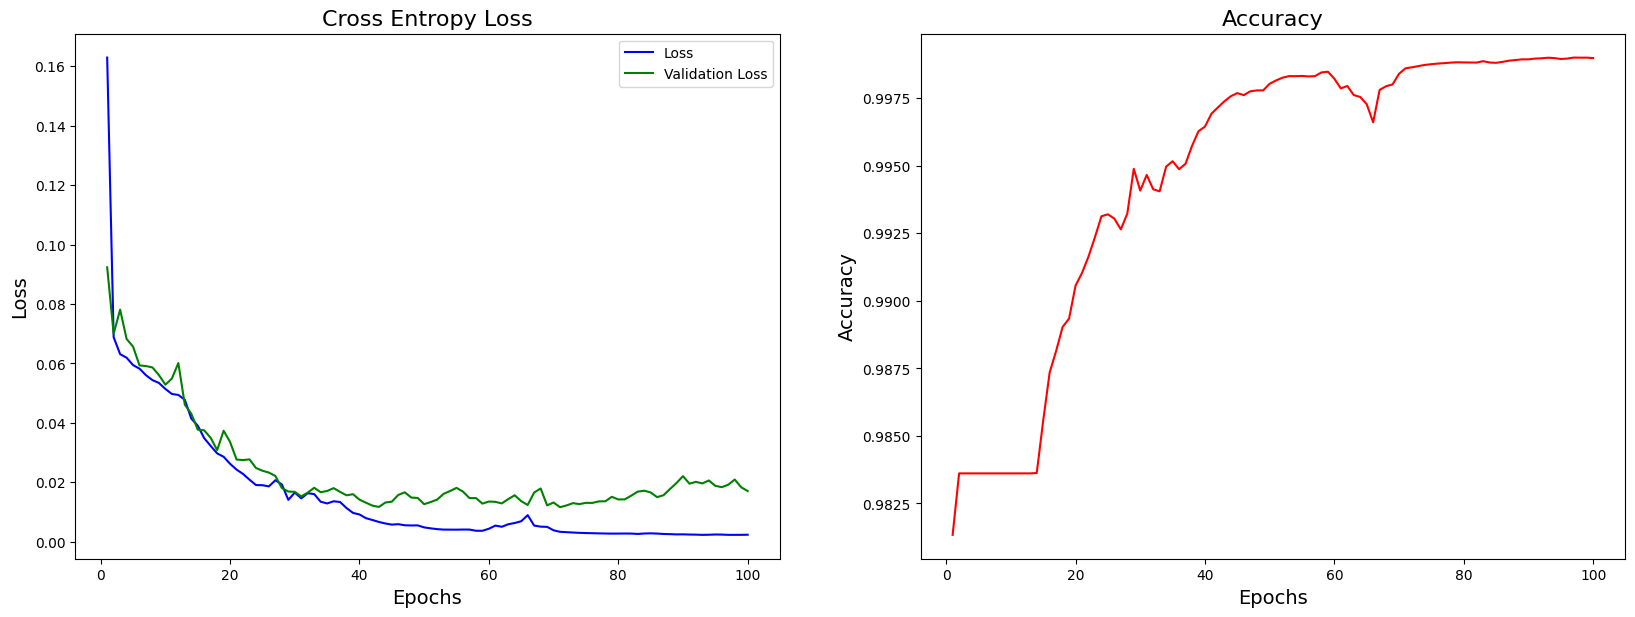

In [19]:
#Exctracting data from our model
loss = history.history['loss']
accuracy = history.history['acc']
epochs = np.arange(1,len(loss)+1)

loss_range = len(loss)
val_loss = history.history['val_loss']

#Creating figures and plotting our losses and accuracy against epochs.
fig = plt.figure(figsize=(20,15))
ax1, ax2 = plt.subplot(2,2,1), plt.subplot(2,2,2)
ax1.plot(epochs,loss,'b',label= 'Loss')
ax1.plot(epochs,val_loss,'g', label = 'Validation Loss')
ax1.legend()
ax1.set_title('Cross Entropy Loss', fontsize='16')
ax1.set_xlabel('Epochs', fontsize = '14')
ax1.set_ylabel('Loss', fontsize = '14')

ax2.plot(epochs,accuracy,'r')
ax2.set_title('Accuracy', fontsize = '16')
ax2.set_xlabel('Epochs', fontsize = '14')
ax2.set_ylabel('Accuracy', fontsize = '14')

We can see that the losses decrease accross the epochs, and the accuracy increases.

Now we can apply our model to the `test_dataset` to inspect if the model is actual able to predict the masks of our test images.

In [20]:
#Predict the masks of our test images
out_ims = model.predict(test_dataset)

6/6 [==============================] - 0s 55ms/step


Text(0.5, 1.0, 'Image and ML Generated Mask')

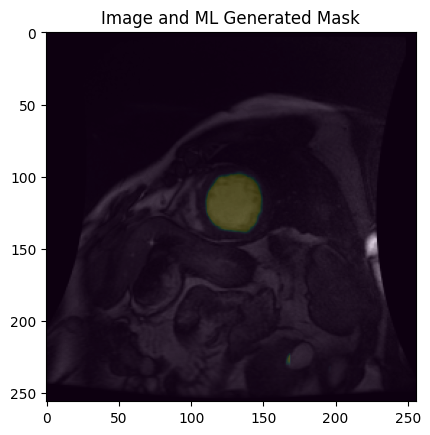

In [21]:
#Plotting a random image and its generated mask
i = rng.randint(0,len(test_images)-1)               #picks a random integer as our image/mask index
plt.imshow(test_images[i], cmap = 'gray')
plt.imshow(out_ims[i], cmap = 'viridis', alpha=0.2)
plt.title('Image and ML Generated Mask')

We can now plot the ground truth test image and mask (the image with its premade mask) next to the image and generated mask to compare.

Text(0.5, 1.0, 'Generated Mask')

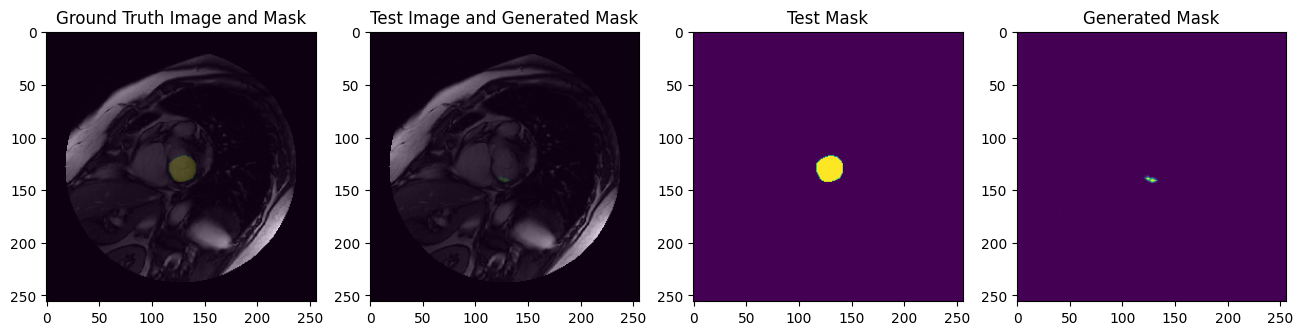

In [22]:
#Once again choosing a random test image and mask
i = rng.randint(0,len(test_images)-1)


figcompare = plt.figure(figsize=(16,12))
ax1, ax2, ax3, ax4 = plt.subplot(2,4,1), plt.subplot(2,4,2), plt.subplot(2,4,3), plt.subplot(2,4,4)

ax1.imshow(test_images[i],cmap='gray')
ax1.imshow(test_masks[i],alpha=0.2)
ax1.set_title("Ground Truth Image and Mask")

ax2.imshow(test_images[i], cmap='gray')
ax2.imshow(out_ims[i],alpha=0.2)
ax2.set_title("Test Image and Generated Mask")

ax3.imshow(test_masks[i])
ax3.set_title('Test Mask')

ax4.imshow(out_ims[i])
ax4.set_title('Generated Mask')


# Conclusion
Congratulations! You've performed image segmentation using TensorFlow Mri. The code in this notebook will work with any 2D dataset, so feel free to use your own. You can also continue to test this model using different parameters, which can be found on [GitHub](https://github.com/mrphys/tensorflow-mri/issues/new).

### Let us know!
Please tell us what you think about this tutorial and about TensorFlow MRI.
We would like to hear what you liked and how we can improve. You will find us
on [GitHub](https://mrphys.github.io/tensorflow-mri/).

In [23]:
# Copyright 2022 University College London. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.